## Hackathon Challenge:

Across the world, COVID-19 cases are constantly fluctuating, often influenced and shaped by public policy, community sentiment and other external factors. The United States of America has seen some of the wildest changes globally, and understanding its inputs requires a deep analysis into the drivers of the infection rate on the local, state and federal level.

The goal is to develop an algorithm that will predict the number of COVID-19 cases in the United States of America, between 27 July to 15 August.

## Importing Libraries

In [1]:
import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Part 1: Building the Model and Comapring Against the Test Data

## Reading train and test data

In [2]:
dicPath = os.getcwd()
dicPathData = os.path.join(dicPath,'Hackathon','us-counties.csv')
dataset = pd.read_csv(dicPathData)

test_dicpathdata = os.path.join(dicPath,'Hackathon','WHO-COVID-19-global-data.csv')
dataset_test = pd.read_csv(test_dicpathdata)

## Data Preprocessing:

    -> handling null values, dirty data having values as "Unknown"
    -> removing the territories of USA to include only USA states

In [3]:
dataset = dataset.replace('Unknown', np.nan)
dataset['county'].isna().sum() 
dataset['county'].isna().sum() 
dataset = dataset[dataset['county'].notna()]

dataset['state'].unique()
dataset = dataset.replace(['Puerto Rico','Virgin Islands','Northern Mariana Islands'], np.nan)
dataset['state'].isna().sum() 
dataset = dataset[dataset['state'].notna()]
dataset['state'].isna().sum() 
dataset['state'].unique()
dataset.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


## Feature Engineering:

Mapping USA states to their respective regions to create a new column "region",to further analyze the data based on regions

In [4]:
regions = {'Maine':'Northeast',' Massachusetts':'Northeast', 'Rhode Island':'Northeast', 'Connecticut':'Northeast', 'New Hampshire':'Northeast', 
 'Vermont':'Northeast', 'New York':'Northeast', 'Pennsylvania':'Northeast', 'New Jersey':'Northeast', 'Delaware':'Northeast', 
 'Maryland':'Northeast','West Virginia':'Southeast', 'Virginia':'Southeast', 'Kentucky':'Southeast', 'Tennessee':'Southeast', 'North Carolina':'Southeast', 
 'South Carolina':'Southeast', 'Georgia':'Southeast',' Alabama':'Southeast','Mississippi':'Southeast', 'Arkansas':'Southeast',' Louisiana':'Southeast', 
 'Florida':'Southeast', 'Ohio':'Midwest', 'Indiana':'Midwest', 'Michigan':'Midwest', 'Illinois':'Midwest', 'Missouri':'Midwest', 
 'Wisconsin':'Midwest', 'Minnesota':'Midwest', 'Iowa':'Midwest', 'Kansas':'Midwest', 'Nebraska':'Midwest', 'South Dakota':'Midwest', 
 'North Dakota':'Midwest','Texas':'Southwest', 'Oklahoma':'Southwest',' New Mexico':'Southwest',' Arizona':'Southwest','Colorado':'West',' Wyoming':'West',
 'Montana':'West', 'Idaho':'West', 'Washington':'West', 'Oregon':'West', 'Utah':'West',' Nevada':'West', 'California':'West', 'Alaska':'West', 'Hawaii':'West'}


dataset['region'] = dataset['state'].map(regions)
dataset.head()

,date,county,state,fips,cases,deaths,region
0,2020-01-21,Snohomish,Washington,53061.0,1,0,West
1,2020-01-22,Snohomish,Washington,53061.0,1,0,West
2,2020-01-23,Snohomish,Washington,53061.0,1,0,West
3,2020-01-24,Cook,Illinois,17031.0,1,0,Midwest
4,2020-01-24,Snohomish,Washington,53061.0,1,0,West


## Exploratory Data Analysis

#### 1) Region v/s Cases

Text(130.75, 0.5, 'Cases')

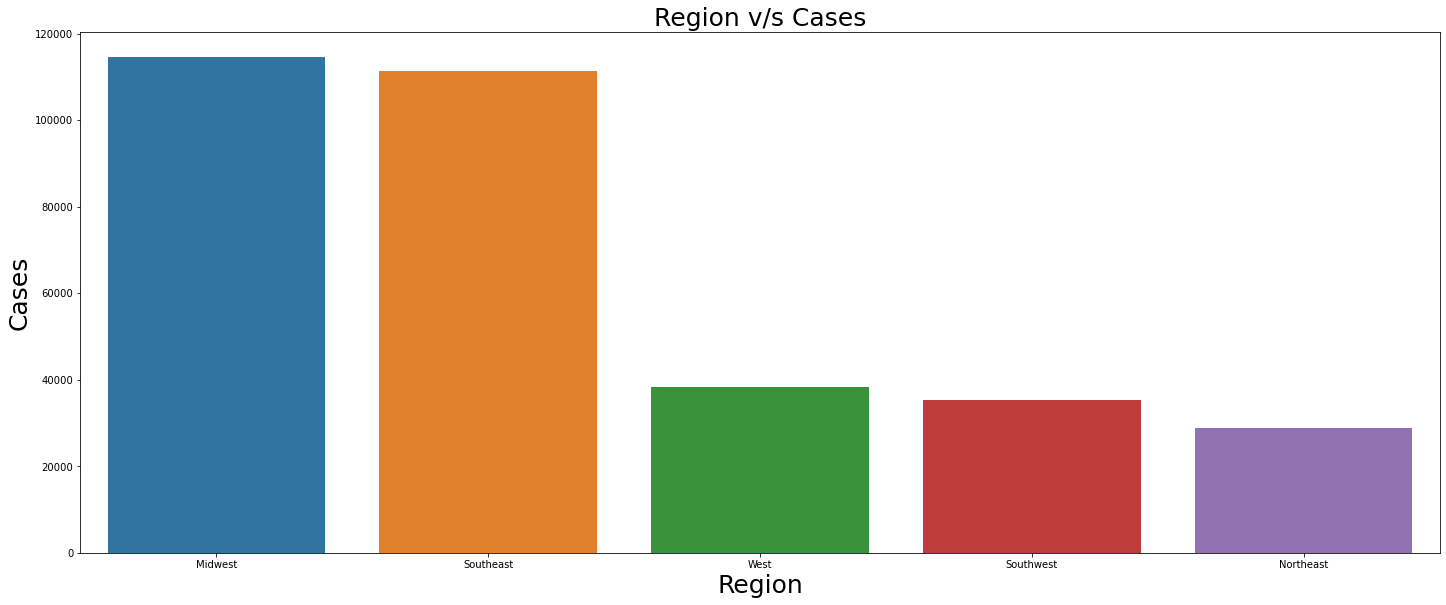

In [5]:
region_grp = dataset.groupby('region')['cases'].count().reset_index().sort_values(by = 'cases', ascending=False)
plt.figure(figsize=(20,8))
b = sns.barplot(x=region_grp['region'],y = region_grp['cases'], data=region_grp)
plt.xticks()
plt.tight_layout()
b.axes.set_title("Region v/s Cases",fontsize=25)
b.set_xlabel("Region",fontsize=25)
b.set_ylabel("Cases",fontsize=25)

As we can see that the maximum number of COVID 19 cases are in Midwest and SouthEast region and it is reflected in the State v/s Cases plot

#### 2) State V/S Cases

Text(137.125, 0.5, 'Cases')

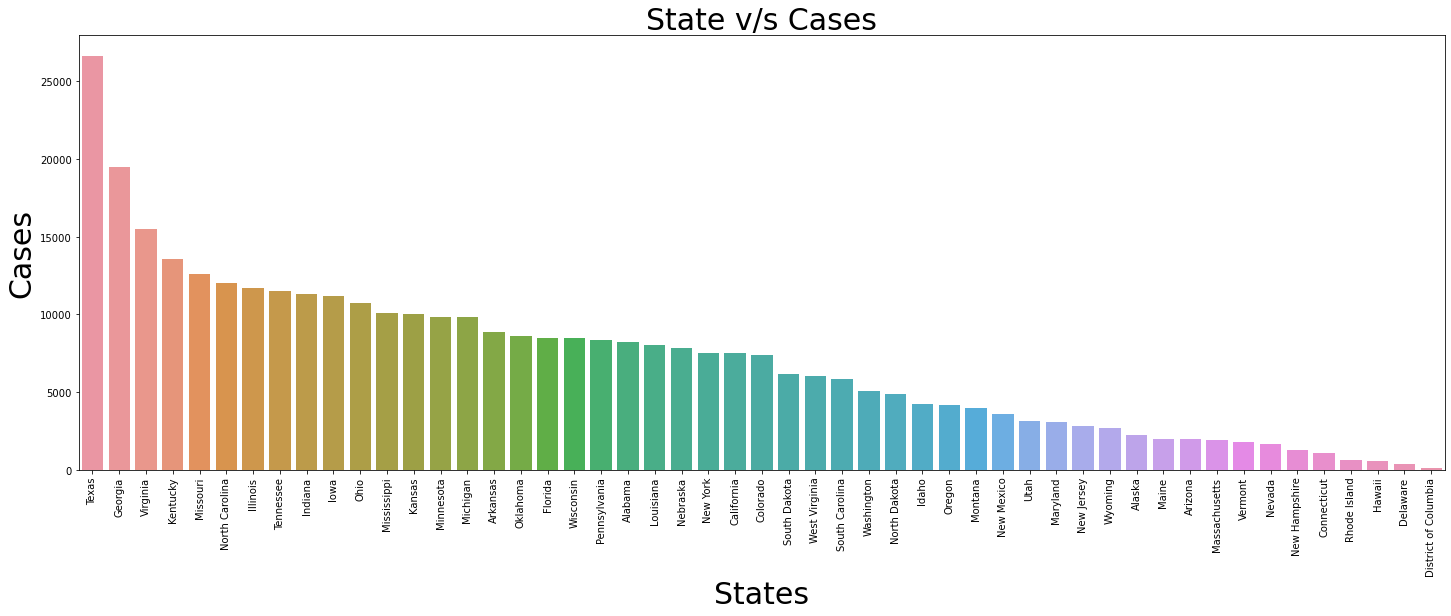

In [6]:
state_grp = dataset.groupby('state')['cases'].count().reset_index().sort_values(by = 'cases', ascending=False)
plt.figure(figsize=(20,8))
a = sns.barplot(x=state_grp['state'],y = state_grp['cases'], data=state_grp)
plt.xticks(rotation=90)
plt.tight_layout()
a.axes.set_title("State v/s Cases",fontsize=30)
a.set_xlabel("States",fontsize=30)
a.set_ylabel("Cases",fontsize=30)

### Plotting Correlations among variables 

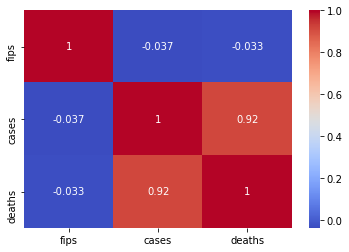

In [7]:
sns.heatmap(dataset.corr(),annot=True, cmap='coolwarm')

     As we can see fips column is weakly correlated with other columns

### Converting categorical variables to numerical variables using label Encoding

In [8]:
dataset['county'] = dataset.county.astype('category')
dataset['state'] = dataset.state.astype('category')
dataset['region'] = dataset.region.astype('category')

cat_columns = dataset.select_dtypes(['category']).columns.tolist()
for col in cat_columns:
    dataset[col] = dataset[col].cat.codes

In [9]:
dataset.head()

,date,county,state,fips,cases,deaths,region
0,2020-01-21,1515,47,53061.0,1,0,4
1,2020-01-22,1515,47,53061.0,1,0,4
2,2020-01-23,1515,47,53061.0,1,0,4
3,2020-01-24,389,13,17031.0,1,0,0
4,2020-01-24,1515,47,53061.0,1,0,4


### Finding total number of cases for a single day and setting "date" column as index for Time Series Analysis

In [10]:
dataset = dataset.groupby(['date'],as_index=False).agg({'cases':sum})
dataset['date'] = dataset['date'].apply(pd.to_datetime)
dataset = dataset.set_index("date")
dataset.head()

,cases
date,
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,3


### Plotting Date v/s Cases to see whether cases are increasing or decreasing

No handles with labels found to put in legend.


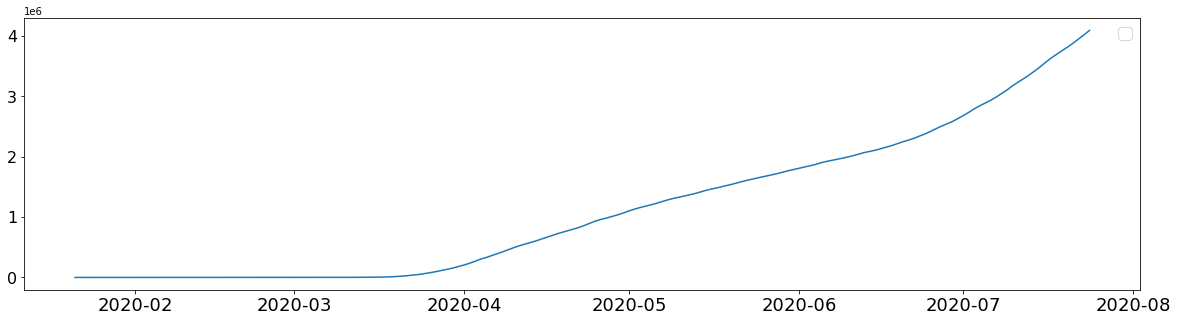

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(dataset.index, dataset['cases'])
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

                    We can observe that the COVID 19 cases are increasing from April till July

### Making test data in accordance to the train data

In [12]:
dataset_test = dataset_test[dataset_test[' Country_code'] == 'US']

dataset_test = dataset_test.drop([' Country',' Country_code',' WHO_region',' New_cases',' New_deaths',' Cumulative_deaths'],axis = 1)

dataset_test['date'] = dataset_test['date'].apply(pd.to_datetime)
dataset_test = dataset_test.set_index("date")


### Performing Normalization of Data before applying LSTM

In [13]:
scaler = MinMaxScaler()
scaler.fit(dataset)
train = scaler.transform(dataset)
test = scaler.transform(dataset_test)

### Applying LSTM model with:

    -> Optimizer as 'Adam'
    -> Loss Function as Mean Squared Error
    -> Dropout as Regularization

In [14]:
n_features = 1
n_input = 20 
batch_size = 1

generator = TimeseriesGenerator(train,train,length=n_input,batch_size=batch_size)

regressor = Sequential()

regressor.add(LSTM(units = 10, input_shape=(n_input,n_features)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

regressor.fit_generator(generator=generator,epochs=20)


Epoch 1/20
166/166 [==============================] - 8s 49ms/step - loss: 0.0535 - accuracy: 0.0000e+00
Epoch 2/20
166/166 [==============================] - 5s 31ms/step - loss: 0.0100 - accuracy: 0.0060 0s - loss: 0.0098 - accuracy: 0.00
Epoch 3/20
166/166 [==============================] - 6s 34ms/step - loss: 0.0087 - accuracy: 0.0060
Epoch 4/20
166/166 [==============================] - 5s 31ms/step - loss: 0.0040 - accuracy: 0.0060
Epoch 5/20
166/166 [==============================] - 5s 33ms/step - loss: 0.0058 - accuracy: 0.0060 1s
Epoch 6/20
166/166 [==============================] - 5s 33ms/step - loss: 0.0067 - accuracy: 0.0060 0s - los
Epoch 7/20
166/166 [==============================] - 5s 31ms/step - loss: 0.0047 - accuracy: 0.0060
Epoch 8/20
166/166 [==============================] - 5s 33ms/step - loss: 0.0046 - accuracy: 0.0060
Epoch 9/20
166/166 [==============================] - 6s 35ms/step - loss: 0.0061 - accuracy: 0.0060
Epoch 10/20
166/166 [===================

### Plotting MSE v/s Epochs to see how our model is performing

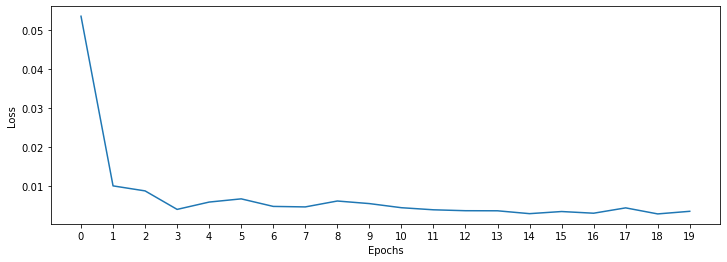

In [15]:
losses_lstm = regressor.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

     As we can see the performance of the model is relatively good as MSE gets decreased in each epoch 

### Getting the list of predictions by model:

    -> create an empty list for each of our 20 predictions
    -> create the batch that our model will predict off 
    -> save the prediction to our list
    -> add the prediction to the end of the batch to be used in the next prediction

In [16]:
test_predictions = []

current_batch = train[-n_input:].reshape(1,n_input,n_features)

for i in range(n_input):
    current_pred = regressor.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

### Applying Reverse scaling in order to see the data in the original format and it is concatenated to the original dataframe

In [17]:
df_predict = pd.DataFrame(scaler.inverse_transform(test_predictions),                           
index = dataset[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([dataset,df_predict], axis=1)

### Plotting Predicted values to the Actual Values

No handles with labels found to put in legend.


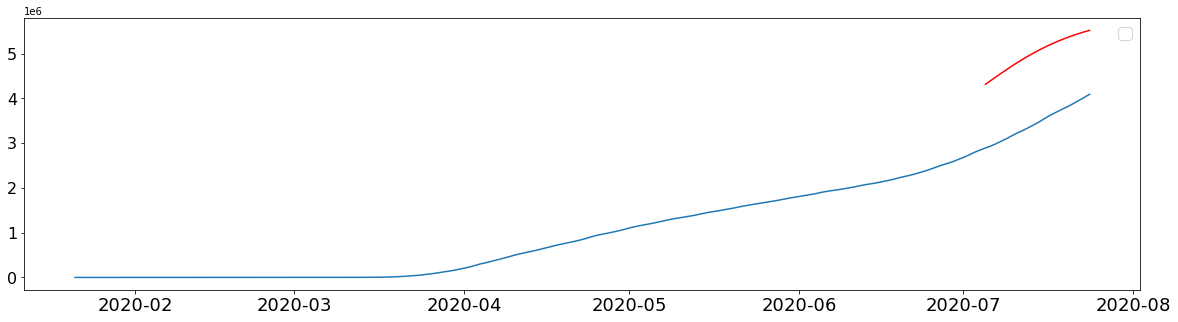

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['cases'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

              As we can see the model is performing well on the test data in predicting the cases







## Part 2: Predicting Beyond the Test Dataset

### It is mainly the same code, except where future dates are added on.

In [21]:
train = dataset
scaler.fit(train)
train = scaler.transform(train)
n_input = 20
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
regressor.fit_generator(generator,epochs=90)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(regressor.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/90
28/28 [==============================] - 1s 31ms/step - loss: 0.0025 - accuracy: 0.0060
Epoch 2/90
28/28 [==============================] - 1s 28ms/step - loss: 0.0027 - accuracy: 0.0060
Epoch 3/90
28/28 [==============================] - 1s 29ms/step - loss: 0.0028 - accuracy: 0.0060
Epoch 4/90
28/28 [==============================] - 1s 32ms/step - loss: 0.0025 - accuracy: 0.0060
Epoch 5/90
28/28 [==============================] - 1s 29ms/step - loss: 0.0022 - accuracy: 0.0060
Epoch 6/90
28/28 [==============================] - 1s 28ms/step - loss: 0.0037 - accuracy: 0.0060
Epoch 7/90
28/28 [==============================] - 1s 29ms/step - loss: 0.0025 - accuracy: 0.0060
Epoch 8/90
28/28 [==============================] - 1s 38ms/step - loss: 0.0028 - accuracy: 0.0060
Epoch 9/90
28/28 [==============================] - 1s 31ms/step - loss: 0.0032 - accuracy: 0.0060ETA: 0s - loss: 0.0031 - accuracy: 0.
Epoch 10/90
28/28 [==============================] - 1s 31ms/step - loss

28/28 [==============================] - 1s 30ms/step - loss: 0.0020 - accuracy: 0.0060
Epoch 81/90
28/28 [==============================] - 1s 40ms/step - loss: 0.0036 - accuracy: 0.0060
Epoch 82/90
28/28 [==============================] - 1s 45ms/step - loss: 0.0015 - accuracy: 0.0060
Epoch 83/90
28/28 [==============================] - 1s 41ms/step - loss: 0.0025 - accuracy: 0.0060
Epoch 84/90
28/28 [==============================] - 1s 40ms/step - loss: 0.0026 - accuracy: 0.0060
Epoch 85/90
28/28 [==============================] - 1s 41ms/step - loss: 0.0023 - accuracy: 0.0060
Epoch 86/90
28/28 [==============================] - 1s 40ms/step - loss: 0.0037 - accuracy: 0.0060
Epoch 87/90
28/28 [==============================] - 1s 37ms/step - loss: 0.0017 - accuracy: 0.0060
Epoch 88/90
28/28 [==============================] - 1s 36ms/step - loss: 0.0024 - accuracy: 0.0060
Epoch 89/90
28/28 [==============================] - 1s 42ms/step - loss: 0.0026 - accuracy: 0.0060
Epoch 90/90


### Creating new dates for the next 20 Days which is from July 27th to August 15th

In [22]:
from pandas.tseries.offsets import DateOffset
add_dates = [dataset.index[-1] + DateOffset(days=x) for x in range(0,21) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=dataset.columns)

### Performing Inverse scaling same as previous except, the index being set to the future dates.

In [23]:
df_predict = pd.DataFrame(scaler.inverse_transform(test_predictions),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([dataset,df_predict], axis=1)

### Here can check out the results of Forecasting from July 27th to August 15th

No handles with labels found to put in legend.


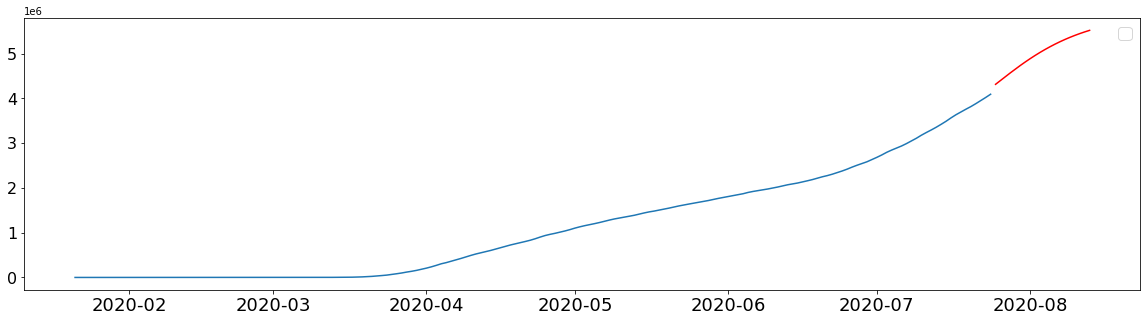

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['cases'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

We can see that the graph is following "upward" trend from July 27th - August 15th indicating that the number of cases will likely to increase between July 27-August 15 and the USA Government should focus more on stopping the spread of COVID 19 by rolling back the opening of certain states where there is a spike like Texas,Georgia,Florida etc and by providing newer guidelines for social distancing, mandating masks, sanitation and hygine, so that the cases can be controlled in future. 